In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.emb_manipulator as em

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models. in any "all models" script we evaluate which one(s) might be best

##files starting with 020422 are from the recent recordings of actual moms sohye sent
## files starting with 020322 were all the test recordings from last year

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("020422")] 
#file = '022822_postpartum_moms_20part_emb_ami.csv'
file = '03016_diarized_pyv2.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down)

#egemap (88 features) for each participant
#gemap_file = '040122_segmented_postpartum_moms_gemaps'
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
#gemap_file = '040622_segmented_postpartum_moms_gemaps_5sec.csv'
gemap = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap = gemap.drop(columns=['start','end'])

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [15]:
import umap

part_to_train_on = 1
train = emb_down[emb_down.part_id!= part_to_train_on].reset_index(drop=True).drop(columns='part_id')
train_labels = emb_down[emb_down.part_id!= part_to_train_on].part_id

test = emb_down[emb_down.part_id== part_to_train_on].reset_index(drop=True).drop(columns='part_id')
test_labels = emb_down[emb_down.part_id== part_to_train_on].part_id

data = np.array(np.vstack([train, test]), dtype=np.float64)
target = np.hstack([train_labels, test_labels])
classes = emb_down.part_id.unique().astype('int32')


In [52]:
embedding = umap.UMAP(n_neighbors=10).fit_transform(data)

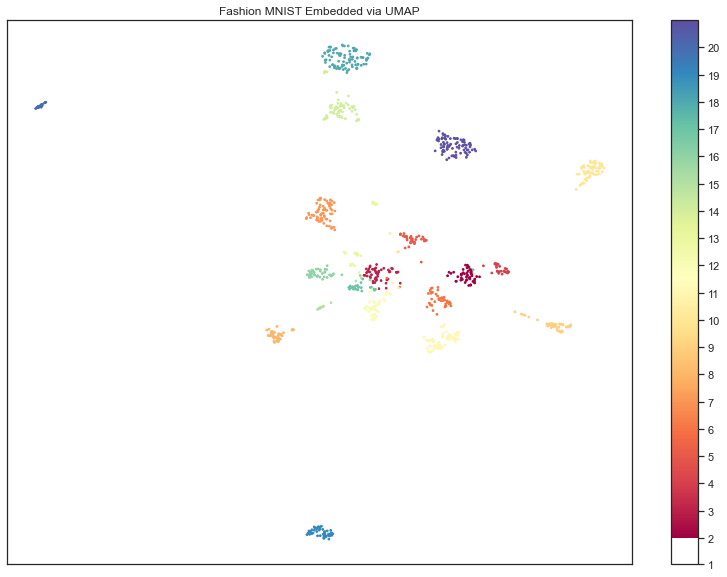

In [53]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP');

In [16]:
train_data = np.array(train)
test_data = np.array(test)
mapper = umap.UMAP(n_neighbors=10).fit(train_data, np.array(train_labels))
test_embedding = mapper.transform(test_data)

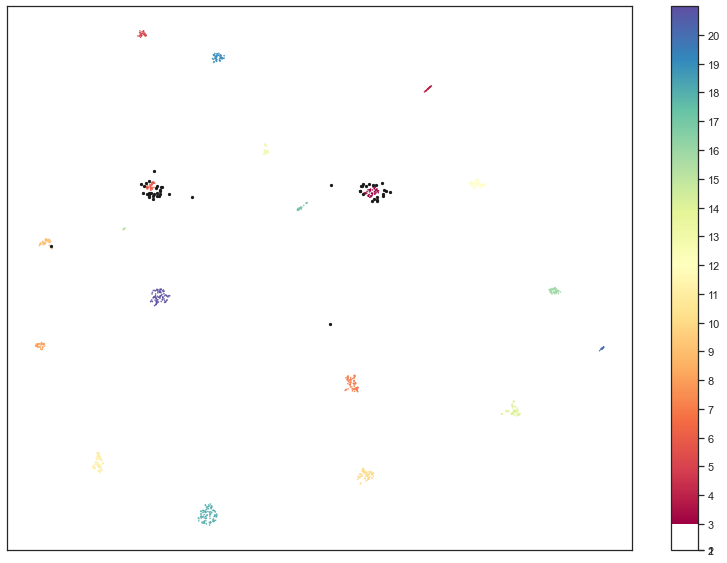

In [29]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(train_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(classes)
plt.scatter(*test_embedding.T, s=5, c='k', alpha=1.0)
plt.show()

In [54]:
high_dim = emb_down.drop(columns='part_id').to_numpy()
labels= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = embedding
dist_umap = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

#metric learned comparison
low_dim = np.vstack((test_embedding,mapper.embedding_))
dist_umap_metric_learn = dm.embedding_quality(high_dim, low_dim, labels,subsetsize=emb_down.shape[0])

In [55]:
np.vstack((dist_umap,dist_umap_metric_learn))

array([[0.10113872, 0.63      , 0.14936369],
       [0.41325052, 0.57      , 0.23985085]])

In [41]:
embedding

array([[10.202949 ,  7.627494 ],
       [ 9.824595 ,  8.132188 ],
       [10.976532 ,  7.3297443],
       ...,
       [12.27635  ,  7.8214955],
       [12.355941 ,  7.626032 ],
       [12.28871  ,  7.704455 ]], dtype=float32)

array([[-7.11276  , 10.181895 ],
       [-6.665683 , 11.705531 ],
       [ 6.5006323, 10.73198  ],
       ...,
       [-6.7665596,  2.8571463],
       [-6.5707316,  3.3733253],
       [-6.5782604,  3.2233114]], dtype=float32)